In [17]:
%reset -f
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

In [18]:
del configs[:]
initial_conditions = {
    'px': 20,
    'lotr': 20,
    'limit': 18,
    'var': 0.25,
}

params = {
    'token_bp_chg_min': [-500,-1000],
    'token_bp_chg_max': [500,1000],
}

MONTE_CARLO_RUNS = 2
SIMULATION_TIMESTEPS = range(10000)
simulation_parameters = {
    'N': MONTE_CARLO_RUNS,
    'T': SIMULATION_TIMESTEPS,
    'M': params
}

In [19]:
def p_px_chg(_params, substep, state_history, state_current, **kwargs):
    random_bp_chg = np.random.randint(_params['token_bp_chg_min'], high=_params['token_bp_chg_max'])
    random_px_chg = random_bp_chg * 0.0001
    return {'px_chg': random_px_chg}

In [20]:
def s_px_update(_params, substep, state_history, state_current, _input, **kwargs):
    new_px = state_current['px'] + (_input['px_chg'] * state_current['px'])
    return ('px', new_px)

# **********************************************************************************************
# LIMIT ORDER TOKEN RESERVE token valuation model
# g = Le^(v(L-p)) for LOTR token value above the limit order price threshold constant
# g = Le^(v(p-L)) for LOTR token value below the limit order price threshold constant
# g = Gandalf LOTR token value
# p = target token price
# L = limit order price threshold constant
# v = asset variance constant
# **********************************************************************************************
def s_lotr_update(_params, substep, state_history, state_current, _input, **kwargs):
    new_px = state_current['px'] + (_input['px_chg'] * state_current['px'])
    
    # The token valuation equation is slightly different depending on whether
    # the target limit price is above or below the current target token price.
    # g = Le^(v(s)) where s = L-p or p-L, the asset price vs. Gandalf token spread
    spread = 0
    if new_px > state_current['limit']:
        # s = L-p
        spread = state_current['limit'] - new_px
    elif new_px < state_current['limit']:
         # s = p-L
        spread = new_px - state_current['limit']
    
    new_lotr = state_current['limit'] * np.exp(state_current['var'] * spread)
    return ('lotr', new_lotr)

In [21]:
partial_state_update_blocks = [
    { 
        'policies': {
            'px_chg': p_px_chg
        },
        'variables': {
            'px': s_px_update,
            'lotr': s_lotr_update
        }
    }
]

In [22]:
sim_config = config_sim(simulation_parameters)

exp = Experiment()
exp.append_configs(sim_configs=sim_config, 
                   initial_state=initial_conditions,
                   partial_state_update_blocks=partial_state_update_blocks)

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context=exec_context, configs=configs) 
(records, tensor_field, session) = executor.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 2
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (10000, 2, 2, 4)
Execution Method: local_simulations
SimIDs   : [0, 0, 1, 1]
SubsetIDs: [0, 0, 1, 1]
Ns       : [0, 1, 0, 1]
ExpIDs   : [0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 1.01s


In [23]:
df = pd.DataFrame(records)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.max_rows", 10, "display.max_columns", 10)
df.set_index(['simulation', 'run', 'timestep', 'substep'])

px       lotr  limit   var  subset
simulation run timestep substep                                           
0          1   0        0        20.000000  20.000000     18  0.25       0
               1        1        20.896000   8.726564     18  0.25       0
               2        1        19.980755  10.970205     18  0.25       0
               3        1        19.385329  12.730995     18  0.25       0
               4        1        20.151049  10.512967     18  0.25       0
...                                    ...        ...    ...   ...     ...
1          2   9996     1         0.000316   0.199978     18  0.25       1
               9997     1         0.000329   0.199978     18  0.25       1
               9998     1         0.000304   0.199977     18  0.25       1
               9999     1         0.000289   0.199976     18  0.25       1
               10000    1         0.000266   0.199975     18  0.25       1

[40004 rows x 5 columns]

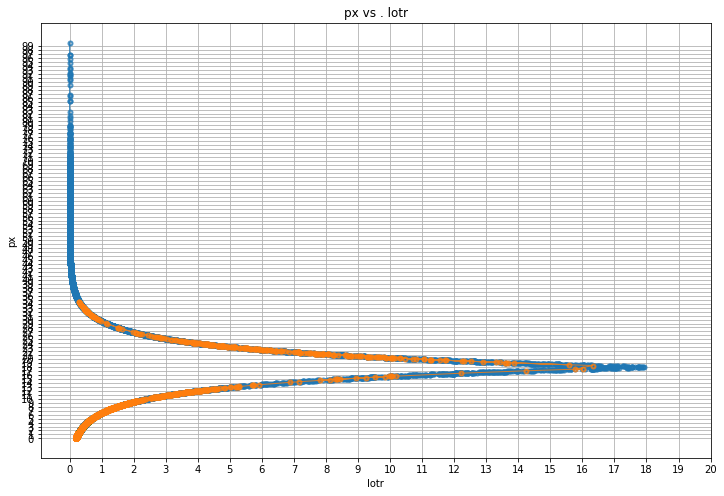

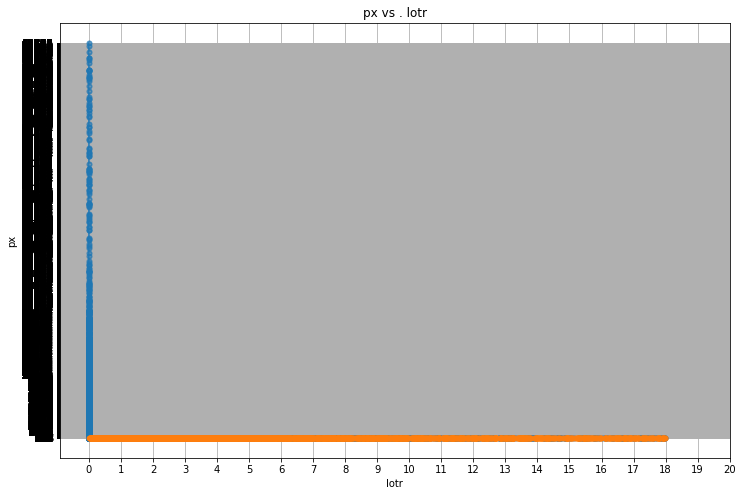

In [24]:
for simulation_id in range(2):
    ax = None
    for i in range(0, MONTE_CARLO_RUNS):
        ax =  df[(df['simulation']==simulation_id) & (df['run']==i+1) & (df['timestep']>0)].plot(x='lotr', y=['px'], marker='o', markersize=2,
                    markeredgewidth=4, alpha=0.8, markerfacecolor='black',
                    linewidth=1, figsize=(12,8),  title="px vs . lotr", 
                    ylabel='px', grid=True, fillstyle='none',  
                    xticks=list(range(1+np.int64(np.max(df[(df['simulation']==simulation_id)]['lotr'])))), legend=None,
                    yticks=list(range(1+np.int64(np.max(df[(df['simulation']==simulation_id)]['px'])))), ax=ax);
#                     yticks=list(range(1+(df[(df['simulation']==simulation_id)]['px']).max())), ax=ax);